In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from alibi_detect.cd import MMDDriftOnline

# ============================================================
# 設定（ここだけ変えればOK）
# ============================================================
NORMAL_CSV  = r"..\sampleData\csv_TEPdata\tuning-data.csv"
ANOMALY_CSV = r"..\sampleData\csv_TEPdata\idv_str1_data.csv"
ANOMALY_CSV = r"..\sampleData\csv_TEPdata\idv_str14_data.csv"


TIME_COL  = None   # "None" ではなく None
LABEL_COL = None

FEATURE_COLS = None          # Noneなら数値列から自動
SENSOR_COLS  = None          # Noneなら FEATURE_COLS を使う（例: ["s1","s2"] に固定も可）


# ============================================================
# 0) 入力
# ============================================================
df_normal = pd.read_csv(NORMAL_CSV)
df_anom   = pd.read_csv(ANOMALY_CSV)

# ============================================================
# 1) 特徴量列
# ============================================================
if FEATURE_COLS is None:
    cols = df_normal.select_dtypes(include=[np.number]).columns.tolist()
    if TIME_COL is not None and TIME_COL in cols: cols.remove(TIME_COL)
    if LABEL_COL is not None and LABEL_COL in cols: cols.remove(LABEL_COL)
    FEATURE_COLS = cols

if SENSOR_COLS is None:
    SENSOR_COLS = FEATURE_COLS

missing = [c for c in SENSOR_COLS if c not in df_anom.columns]
if missing:
    raise ValueError(f"ANOMALY_CSV に列がありません: {missing}")

X_ref_all = df_normal[SENSOR_COLS].to_numpy(np.float32)
X_test    = df_anom[SENSOR_COLS].to_numpy(np.float32)

# ============================================================
# 2) 参照を範囲で切り出し → 標準化（参照でfit）
# ============================================================
X_ref   = X_ref_all

scaler     = StandardScaler()
X_ref_std  = scaler.fit_transform(X_ref).astype(np.float32)
X_test_std = scaler.transform(X_test).astype(np.float32)

print(f"参照データ: {X_ref_std.shape}, テストデータ: {X_test_std.shape}")


参照データ: (960, 52), テストデータ: (960, 52)


In [17]:
# 参照データ（標準化後）が「平均≈0、標準偏差≈1」になっているか
mu = X_ref_std.mean(axis=0)
sd = X_ref_std.std(axis=0, ddof=0)

print("max |mean|:", float(np.max(np.abs(mu))))
print("std min/max:", float(np.min(sd)), float(np.max(sd)))

# 参照データで分散がほぼ0の列（ほぼ一定列）を特定
near_const = np.where(scaler.var_ < 1e-12)[0]
print("near-constant columns:", near_const)
print("names:", [SENSOR_COLS[i] for i in near_const[:20]])

print("X_ref NaN:", np.isnan(X_ref).any(), "inf:", np.isinf(X_ref).any())
print("X_ref_std NaN:", np.isnan(X_ref_std).any(), "inf:", np.isinf(X_ref_std).any())


max |mean|: 9.961227624444291e-05
std min/max: 0.9999999403953552 1.0
near-constant columns: []
names: []
X_ref NaN: False inf: False
X_ref_std NaN: False inf: False


In [18]:

# ============================================================
# 3) Online MMD の学習
# ============================================================
# Online MMD
window_size  = 50
ert          = 20.0
n_bootstraps = 1000
backend      = "tensorflow"  # "pytorch" でも可


cd = MMDDriftOnline(
    x_ref=X_ref_std,
    ert=ert,
    window_size=window_size,
    backend=backend,
    n_bootstraps=n_bootstraps,
    verbose=True
)


Generating permutations of kernel matrix..


Computing thresholds: 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


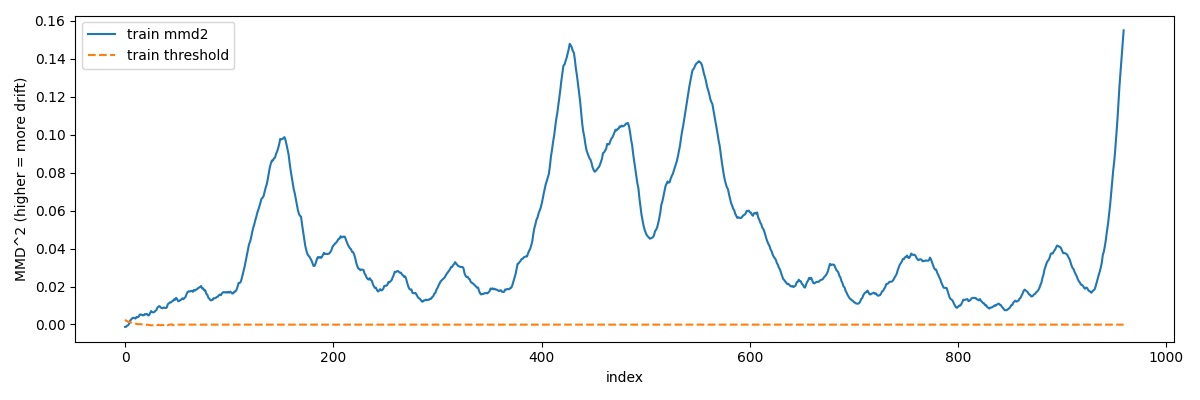

In [19]:
%matplotlib widget

# ============================================================
# 4) 正常(df_normal) を流してスコア算出＋可視化
# ============================================================

FIGSIZE = (12, 4)
YLIM    = None  # 例: (0, 5.0)


n_tr = X_ref_std.shape[0]
mmd2_tr = np.full(n_tr, np.nan, float)
thr_tr  = np.full(n_tr, np.nan, float)
dr_tr   = np.zeros(n_tr, int)

for i in range(n_tr):
    out = cd.predict(X_ref_std[i], return_test_stat=True)
    d = out["data"]
    mmd2_tr[i] = float(d.get("test_stat", np.nan))
    thr_tr[i]  = float(d.get("threshold", np.nan))
    dr_tr[i]   = int(d.get("is_drift", 0))

t_tr = df_normal[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_normal.columns) else np.arange(n_tr)

df_log_train = pd.DataFrame({
    "i": np.arange(n_tr),
    "t": t_tr,
    "mmd2": mmd2_tr,
    "threshold": thr_tr,
    "is_drift": dr_tr
})


plt.figure(figsize=FIGSIZE)
plt.plot(df_log_train["t"], df_log_train["mmd2"], label="train mmd2")
plt.plot(df_log_train["t"], df_log_train["threshold"], "--", label="train threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_normal.columns) else "index")
plt.ylabel("MMD^2 (higher = more drift)")
if YLIM is not None: plt.ylim(*YLIM)
plt.legend(); plt.tight_layout(); plt.show()


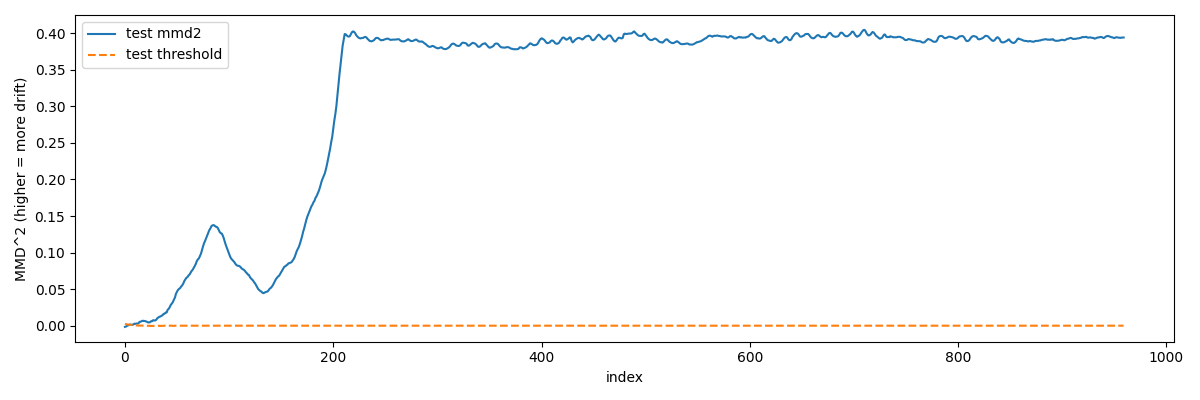

In [20]:

# ============================================================
# 5) train の後に test を流すなら必須（状態を初期化）
# ============================================================
cd.reset_state()

# ============================================================
# 6) テスト(df_anom) を流してスコア算出＋可視化
# ============================================================

n_te = X_test_std.shape[0]
mmd2_te = np.full(n_te, np.nan, float)
thr_te  = np.full(n_te, np.nan, float)
dr_te   = np.zeros(n_te, int)

for i in range(n_te):
    out = cd.predict(X_test_std[i], return_test_stat=True)
    d = out["data"]
    mmd2_te[i] = float(d.get("test_stat", np.nan))
    thr_te[i]  = float(d.get("threshold", np.nan))
    dr_te[i]   = int(d.get("is_drift", 0))

t_te = df_anom[TIME_COL].to_numpy() if (TIME_COL and TIME_COL in df_anom.columns) else np.arange(n_te)

df_log_test = pd.DataFrame({
    "i": np.arange(n_te),
    "t": t_te,
    "mmd2": mmd2_te,
    "threshold": thr_te,
    "is_drift": dr_te
})


plt.figure(figsize=FIGSIZE)
plt.plot(df_log_test["t"], df_log_test["mmd2"], label="test mmd2")
plt.plot(df_log_test["t"], df_log_test["threshold"], "--", label="test threshold")
plt.xlabel("t" if (TIME_COL and TIME_COL in df_anom.columns) else "index")
plt.ylabel("MMD^2 (higher = more drift)")
if YLIM is not None: plt.ylim(*YLIM)
plt.legend(); plt.tight_layout(); plt.show()
